# 2)

The following code contains a function biharmonic_solver that takes inn 2D arrays of X, Y, and F which represents the equation on a given grid. The domain and its side lengths can have different values before they're put into the function. The function then transforms F and runs a spectral derivative method to find a numerical solution. User defined mean value is the average value of the exact solution.

The errors are [3165.45171007151, 23.652206487369874, 0.513636364956479, 6.106226635438361e-15, 5.728750807065808e-14, 7.616129948928574e-14]
EOC between N=4 and N=8: 7.0643
EOC between N=8 and N=15: 6.0923
EOC between N=15 and N=16: 496.8076
EOC between N=16 and N=20: -10.0329
EOC between N=20 and N=32: -0.6059
Surface plots for N_x = 15:


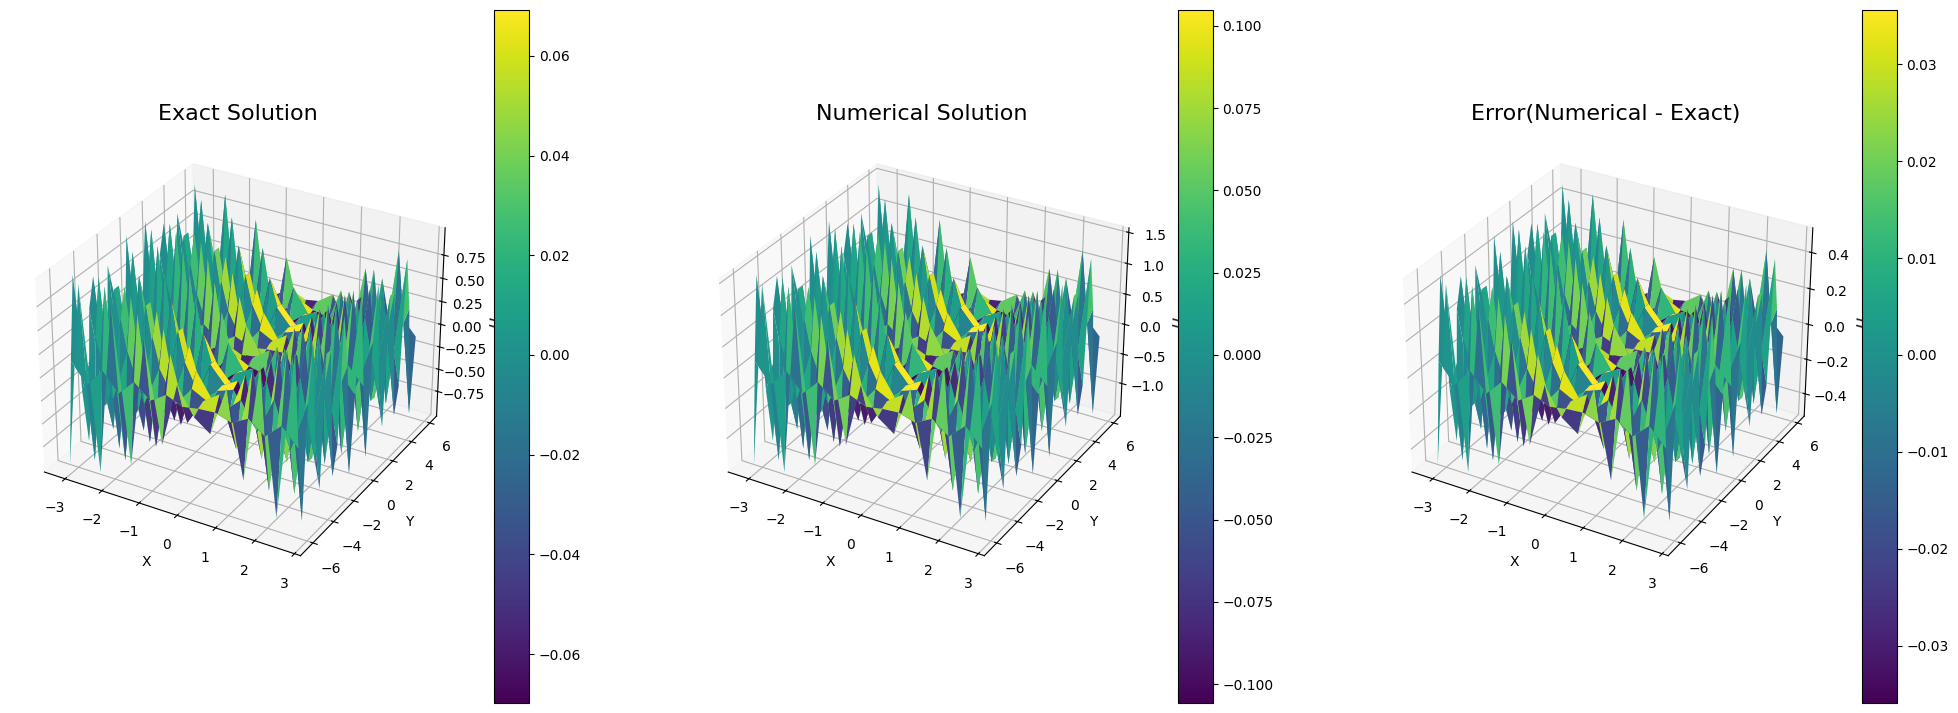

In [2]:
import sympy
from scipy.fft import fft2, ifft2, fftfreq
import numpy as np
import matplotlib.pyplot as plt
from sympy import diff

#Code template
# def biharmonic_solver(X, Y, F, c, mean=0.0):
#     """
#     Solve the biharmonic equation in 2D using the spectral method.

#     Parameters:
#         X (ndarray): 2D array of x-coordinates.
#         Y (ndarray): 2D array of y-coordinates.
#         F (ndarray): 2D array representing the right-hand side of the biharmonic equation.
#         c (float): Constant coefficient in the biharmonic equation.
#         mean (float, optional): Desired mean value of the solution in case c = 0. Default is 0.0.

#     Returns:
#         U (ndarray): 2D array representing the solution to the biharmonic equation.
#     """
#     pass # Add your code here



#Symbolic variables for x, y, and c are needed for the exact solution
x, y, c = sympy.symbols('x y c')

#Symbolic Biharmonic operator
laplace = lambda u: sympy.diff(u, x, x) + sympy.diff(u, y, y)

#Exact solution
def u_ex(x, y):
    return np.sin(8*(x-1))*np.cos(4*y)

#Symbolic exact solution
u_symbol = sympy.sin(8*(x-1))*sympy.cos(4*y)
f_symbol = laplace(laplace(u_symbol))+c*u_symbol
f = sympy.lambdify((x, y, c), f_symbol, modules='numpy')

c=1

#A solver function that takes inn 2D arrays of X, Y, and F which represents the equation on a given grid. mean is the average of the exact solution for correction.  
def biharmonic_solver(X, Y, F, c, mean=0.0):
    #The Fourier transform of the input function F
    F_hat = fft2(F)
    #The wave numbers for the x and y directions
    kx = fftfreq(X.shape[1], d=(X[0, 1] - X[0, 0]))*2*np.pi
    ky = fftfreq(Y.shape[0], d=(Y[1, 0] - Y[0, 0]))*2*np.pi
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    #The wave numbers raised to the fourth power
    K2 = (KX**2 + KY**2)**2
    #Avoiding divition by 0
    K2[0, 0] = 1
    #Fourier transform of the solution
    U_hat = F_hat / (c+K2)
    #Set the zero frequency component to zero if c is very small. Tolerance is chosen to be 0.00001, which is resonable.
    if c < 0.00001*np.min(KX)**4:
        U_hat[0, 0] = 0
    U = ifft2(U_hat).real
    #Adjust the mean of the solution if c is small
    if c < 0.00001*np.min(KX)**4:
        U -= np.mean(U) - mean
    return U


N_values = [4, 8, 15, 16, 20, 32]  # Different amount of points
errors = []
for N_x in N_values:
    #Number of points in the y direction
    N_y = N_x * 2
    #Other grid lengths can be chosen, but for this exersice they are:
    L_x = 2 * np.pi
    L_y = 4 * np.pi
    X_points = np.linspace(-L_x / 2, L_x / 2, N_x, endpoint=False)
    Y_points = np.linspace(-L_y / 2, L_y / 2, N_y, endpoint=False)
    X, Y = np.meshgrid(X_points, Y_points)
    #The right-hand side of the biharmonic equation
    F = f(X,Y,1)
    #Exact solution of a grid
    U_ex = u_ex(X, Y)
    #The average value
    average = np.average(U_ex)
    U_num = biharmonic_solver(X, Y, F, c=1, mean=average)
    error = np.max(np.abs(U_num - U_ex))
    errors.append(error)
    #Handling the case of N_x = 15
    if N_x == 15:
        X_15 = X
        Y_15= Y
        U_Num_15 = U_num
        U_ex_15 = u_ex(X, Y)
    #Handling the case of N_x = 16
    elif N_x == 16:
        X_16 = X
        Y_16= Y
        U_Num_16 = U_num
        U_ex_16 = u_ex(X, Y)
        




print(f'The errors are {errors}')
#store the order of convergence
EOC = []
#Calculate the order of convergence between runs
for i in range(1, len(errors)):
    eoc = -np.log(errors[i-1] / errors[i]) / np.log(N_values[i-1] / N_values[i])
    EOC.append(eoc)

for i in range(len(EOC)):
    print(f"EOC between N={N_values[i]} and N={N_values[i+1]}: {EOC[i]:.4f}")

print("Surface plots for N_x = 15:")

fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(131, projection='3d')
surf = ax.plot_surface(X_15, Y_15, U_ex_15, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$U_\mathrm{ex}$')
ax.set_title("Exact Solution", fontsize=16)


ax = fig.add_subplot(132, projection='3d')
surf = ax.plot_surface(X_15, Y_15, U_Num_15, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$U_\mathrm{ex}$')
ax.set_title("Numerical Solution", fontsize=16)


ax = fig.add_subplot(133, projection='3d')
surf = ax.plot_surface(X_15, Y_15, U_Num_15-U_ex_15, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$U_\mathrm{ex}$')
ax.set_title("Error(Numerical - Exact)", fontsize=16)
plt.show()



We see a dramatic spike in EOC between $N_{x} = 15$ and $N_{x} = 16$ which results in a machine presition error of order $10^{-15}$ for the latter amount of sampling points. It might be a consecounce of both expected and numerical solutions scaling down to the same level of $10^{-15}$ as well as combination of increased resolutionand improved numerical stability. It can be observed that while the error surface plot for $N_{x} = 15$ resembles both solutions almost identically, That is not the case for $N_{x} = 16$. The error is noticably smaller around negative values of $x$, particularly around $x=-2$.

Surface plots for N_x = 16:


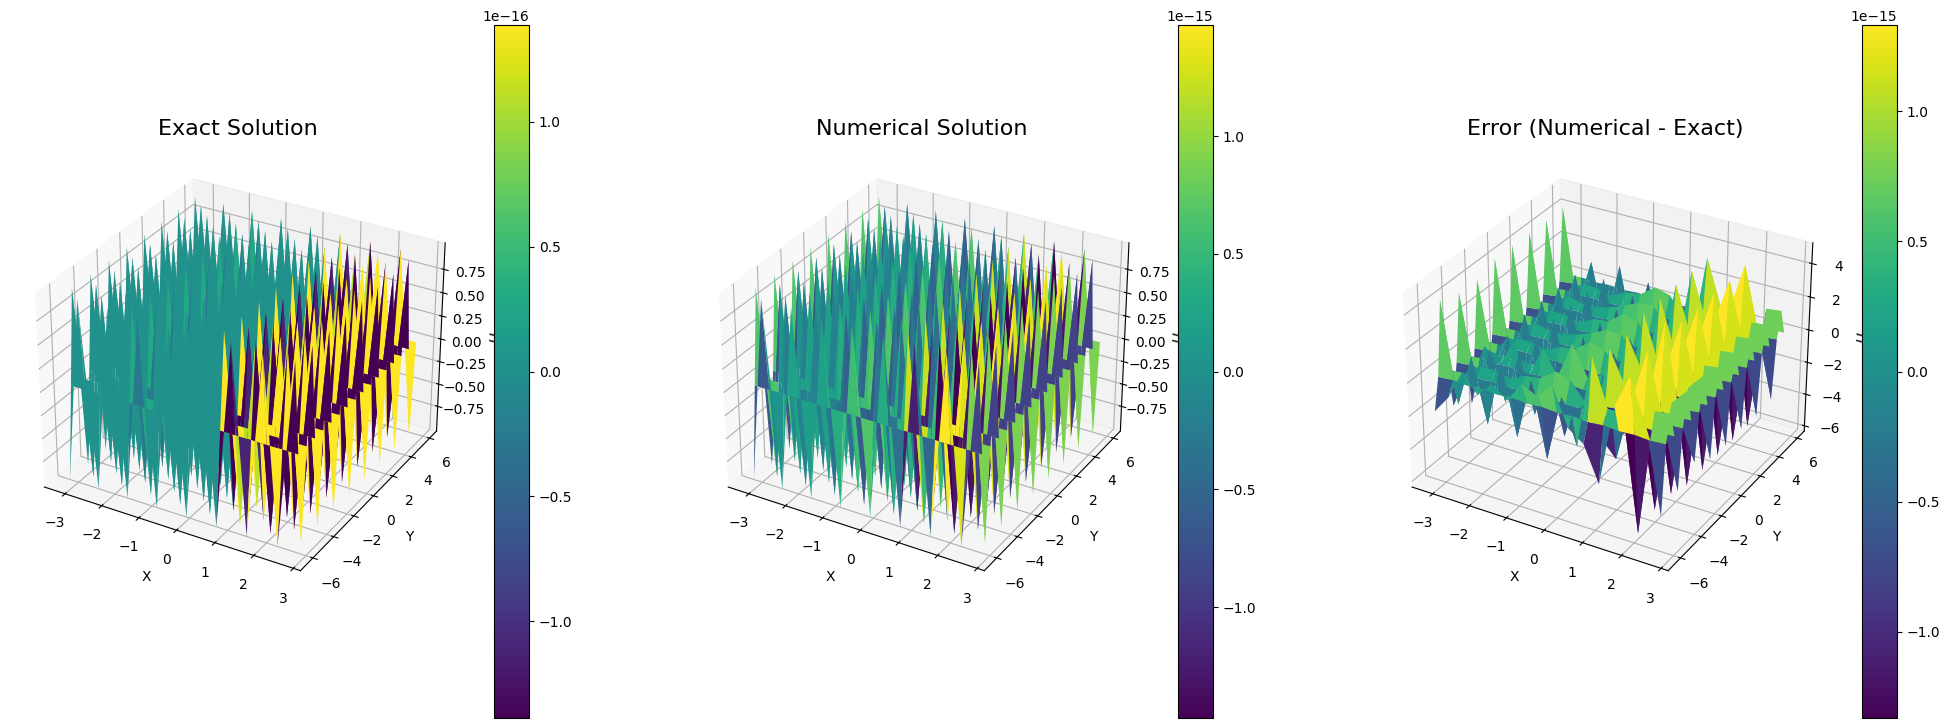

In [67]:
print("Surface plots for N_x = 16:")
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(131, projection='3d')
surf = ax.plot_surface(X_16, Y_16, U_ex_16, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$U_\mathrm{ex}$')
ax.set_title("Exact Solution", fontsize=16)


ax = fig.add_subplot(132, projection='3d')
surf = ax.plot_surface(X_16, Y_16, U_Num_16, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$U_\mathrm{ex}$')
ax.set_title("Numerical Solution", fontsize=16)



ax = fig.add_subplot(133, projection='3d')
surf = ax.plot_surface(X_16, Y_16, U_Num_16-U_ex_16, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$U_\mathrm{ex}$')
ax.set_title("Error (Numerical - Exact)", fontsize=16)
plt.show()

the errors are [20.241044014191313, 10.623049174589891, 0.9844063493774078, 0.03462556441129827, 0.0009929320044053114, 3.601908866190939e-05, 1.5070640229097876e-06, 6.313802103363741e-08, 2.5305686435217467e-09, 9.627232344655567e-11]
EOC between N=4 and N=8: 0.9301
EOC between N=8 and N=12: 5.8667
EOC between N=12 and N=16: 11.6359
EOC between N=16 and N=20: 15.9166
EOC between N=20 and N=24: 18.1910
EOC between N=24 and N=28: 20.5895
EOC between N=28 and N=32: 23.7592
EOC between N=32 and N=36: 27.3119
EOC between N=36 and N=40: 31.0270
Surface plots for N_x = 32:


Text(0.5, 0.92, 'Error (Numerical - Exact)')

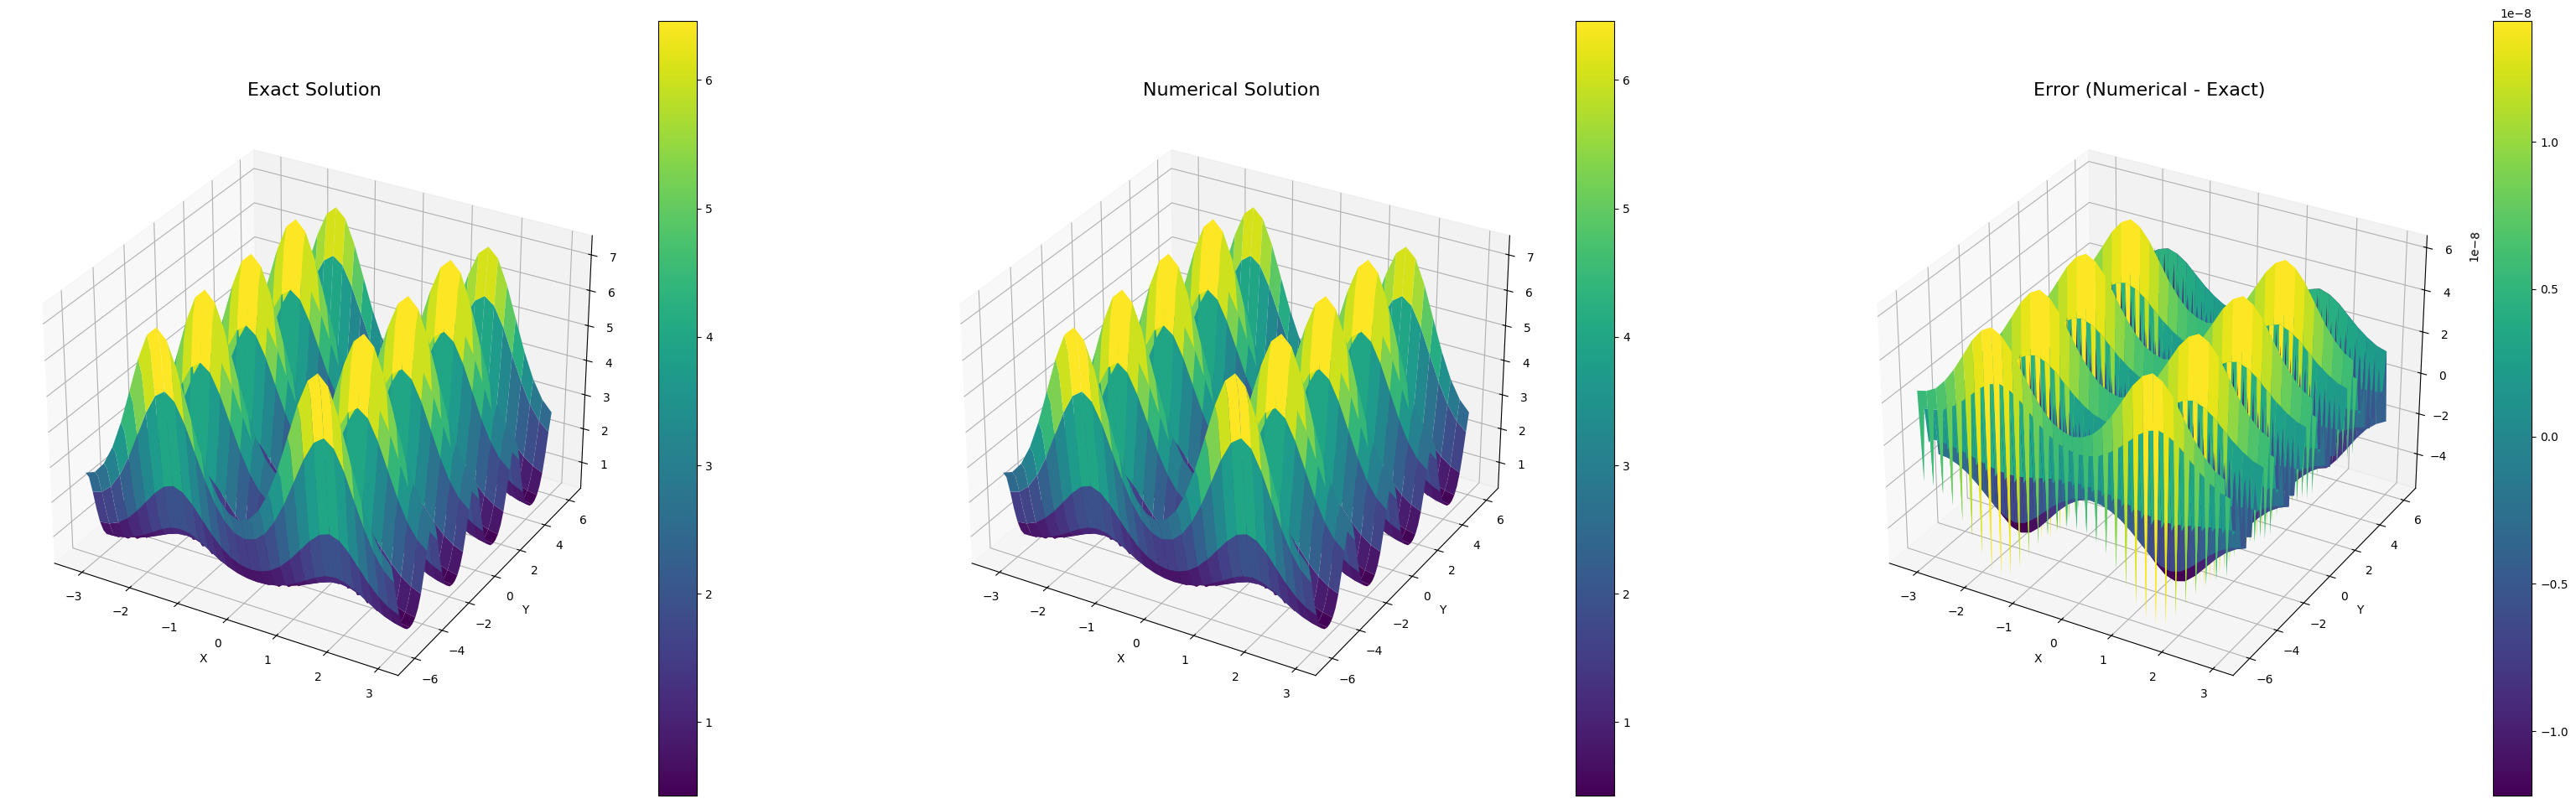

In [3]:

#Symbolic variables for x, y are needed for the exact solution
x, y = sympy.symbols('x y')
laplace = lambda u: sympy.diff(u, x, x) + sympy.diff(u, y, y)

#Exact solution
def u_ex(x, y):
    return np.e**(np.sin(x)**2+np.cos(2*y))

#Symbolic exact solution
u_symbol = sympy.exp(sympy.sin(x)**2+sympy.cos(2*y))
f_symbol = laplace(laplace(u_symbol))

f = sympy.lambdify((x, y), f_symbol, modules='numpy')

c=0

#A solver function that takes inn 2D arrays of X, Y, and F which represents the equation on a given grid. mean is the average of the exact solution for correction.  
def biharmonic_solver(X, Y, F, c, mean=0.0):
    #The Fourier transform of the input function F
    F_hat = fft2(F)
    #The wave numbers for the x and y directions
    kx = fftfreq(X.shape[1], d=(X[0, 1] - X[0, 0]))*2*np.pi
    ky = fftfreq(Y.shape[0], d=(Y[1, 0] - Y[0, 0]))*2*np.pi
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    #The wave numbers raised to the fourth power
    K2 = (KX**2 + KY**2)**2
    #Avoiding divition by 0
    K2[0, 0] = 1
    #Fourier transform of the solution
    U_hat = F_hat / (c+K2)
    #Set the zero frequency component to zero if c is very small. Tolerance is chosen to be 0.00001, which is resonable.
    if c < 0.00001*np.min(KX)**4:
        U_hat[0, 0] = 0
    U = ifft2(U_hat).real
    #Adjust the mean of the solution if c is small
    if c < 0.00001*np.min(KX)**4:
        U -= np.mean(U) - mean
    return U


#Amount of sampling points for x
N_values = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
errors = []
for N_x in N_values:
    N_y = N_x * 2
    L_x = 2 * np.pi
    L_y = 4 * np.pi
    X_points = np.linspace(-L_x / 2, L_x / 2, N_x, endpoint=False)
    Y_points = np.linspace(-L_y / 2, L_y / 2, N_y, endpoint=False)
    X, Y = np.meshgrid(X_points, Y_points)
    F= f(X,Y)
    U_ex = u_ex(X, Y)
    average = np.average(U_ex)
    U_num = biharmonic_solver(X, Y, F, c, mean=average)
    error = np.max(np.abs(U_num - U_ex))
    errors.append(error)
    if N_x == 32:
        X_32 = X
        Y_32 = Y
        U_Num_32 = U_num
        U_ex_32 = u_ex(X, Y)


print(f'the errors are {errors}')
EOC = []
for i in range(1, len(errors)):
    eoc = np.log(errors[i-1] / errors[i]) / np.log(N_values[i] / N_values[i-1])
    EOC.append(eoc)

for i in range(len(EOC)):
    print(f"EOC between N={N_values[i]} and N={N_values[i+1]}: {EOC[i]:.4f}")


print("Surface plots for N_x = 32:")
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(131, projection='3d')
surf = ax.plot_surface(X_32, Y_32, U_ex_32, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("Exact Solution", fontsize=16)


ax = fig.add_subplot(132, projection='3d')
surf = ax.plot_surface(X_32, Y_32, U_Num_32, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("Numerical Solution", fontsize=16)



ax = fig.add_subplot(133, projection='3d')
surf = ax.plot_surface(X_32, Y_32, U_Num_32-U_ex_32, cmap='viridis', antialiased=True)
fig.colorbar(surf, shrink=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("Error (Numerical - Exact)", fontsize=16)




The error surface has similar pattern as both of the solutions. It can be observed that the error drops exponentially as $N_{x}$ rises. It didn't reach machine presition, but it is worth noticing that both of the surface plots have shape many orders of magnitude bigger than the error at $N_{32}$. That leads to the conclusion that the biharmonic_solver has a high degree of accuracy when provided with enough sampling data. When the amount of sampling points is low, the error will be quite substantial. The amount of samplings points needed to reach smallest error possible and most precice numerical solution seem to be dependant on $u$ and constant coeffitient $c$, since biharmonic_solver is the same for both of the tests.